# Time series analysis on GCP 

## Dataset used - 
Ridership(https://data.cityofchicago.org/Transportation/CTA-Ridership-Daily-Boarding-Totals/6iiy-9s97)

## Goal-
To perdict the future ridership of passengers based on the previous years data



## Installing the required packages and libraries

In [1]:
%pip install -U statsmodels scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


**Note:** To restart the Kernel, navigate to Kernel > Restart Kernel... on the Jupyter menu.

### Import libraries and define constants

In [2]:
# importing pandas to handle the time series data frame
# importing statsmodel to handle the statistics involved with time series data
from pandas.plotting import register_matplotlib_converters
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

# importing matpotlib and seaborn for visualising the data
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Setting up the vertex ai environment with region name and project to use.

In [3]:
# Project Name
PROJECT = 'vertex-ai-projects' 

# Region Name
REGION = 'us-west1'

Initialising the variables

In [4]:
# variable to be predicted.
target_col = 'total_rides' 
target_description = 'Total Rides' 

# Weekday = W, Saturday = A, Sunday/Holiday = U
features = {'day_type': 'Day Type'} 

# Date field
ts_col = 'service_date' 

# downlaod file from source
raw_data_file = 'https://data.cityofchicago.org/api/views/6iiy-9s97/rows.csv?accessType=DOWNLOAD'

# output file
processed_file = 'cta_ridership.csv' 

## Ingesting the data

In [5]:
# Importing the file
# for Index and Parse_dates parameters, we pass the data column for time series analysis
df = pd.read_csv(raw_data_file, index_col=[ts_col], parse_dates=[ts_col])

# Data prior to 2020 is taken for training
df = df[df.index < '2020-01-01']

# Dropping any duplicate values
df = df.drop_duplicates()

# Sorting data according to date
df = df.sort_index()

# Exploring the loaded data
df.head()

day_type     bus  rail_boardings  total_rides
service_date                                              
2001-01-01          U  297192          126455       423647
2001-01-02          W  780827          501952      1282779
2001-01-03          W  824923          536432      1361355
2001-01-04          W  870021          550011      1420032
2001-01-05          W  890426          557917      1448343

## Exploratory Date Analysis
### Pattern analysis

* how is ridership changing with time?
* how ridership changes with the day of week?
* how is ridership changing w.r.t bus vs train with time?

In [6]:
# Initialising the plots
# warning registers the conflicts between pandas and matplotlib
register_matplotlib_converters() 
sns.set(rc={'figure.figsize':(16,4)})

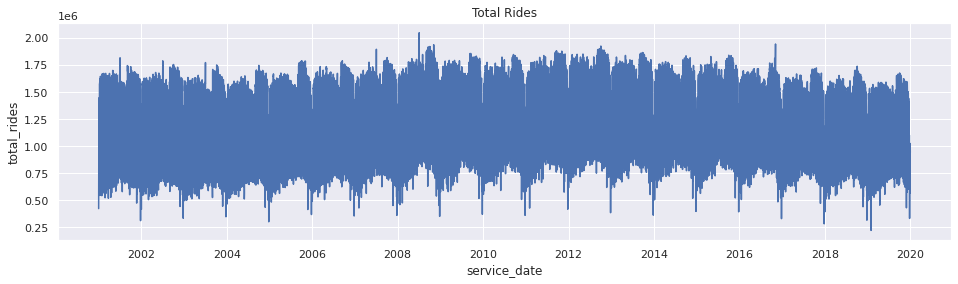

In [7]:
# Exploring the riders over time
sns.lineplot(data=df, x=df.index, y=df[target_col]).set_title('Total Rides')
fig = plt.show()

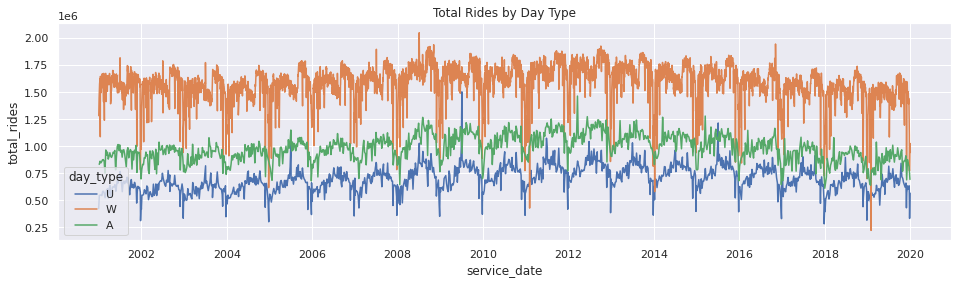

In [8]:
# Exploring the rides by type of the day given in the dataset
# Weekday (W)
# Saturday (A) 
# Sunday/Holiday (U)
sns.lineplot(data=df, x=df.index, y=df[target_col], hue=df['day_type']).set_title('Total Rides by Day Type')
fig = plt.show()

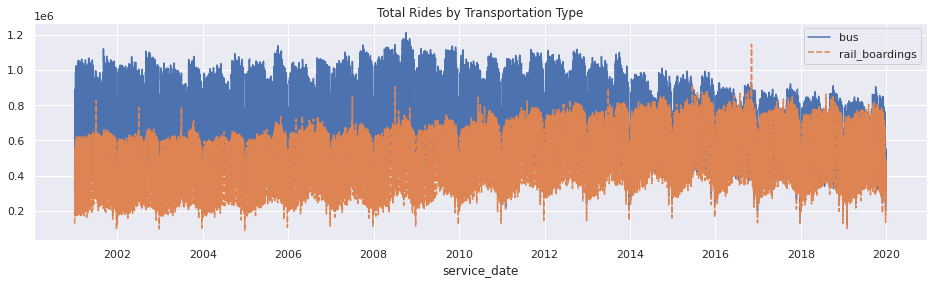

In [9]:
# Exploring the rides by the mode of transportation either bus or train

sns.lineplot(data=df[['bus','rail_boardings']]).set_title('Total Rides by Transportation Type')
fig = plt.show()

### Statistics measures

* total number of records in the dataset?
* average number of riders/day?


In [10]:
# describing the data after rounding of the exponential part for easy understanding
df[target_col].describe().apply(lambda x:round(x))


count       6939
mean     1368761
std       391443
min       222071
25%      1005394
50%      1548343
75%      1660947
max      2049519
Name: total_rides, dtype: int64

### Exploring the Seasonality of time series data

* difference between the months and years?
* Can I look out for trends after looking at the plot of the data

In [11]:
# visualising the boxplot for day of week analysis of the ridership

daysofweek = df.index.to_series().dt.dayofweek

fig = sns.boxplot(x=daysofweek, y=df[target_col])

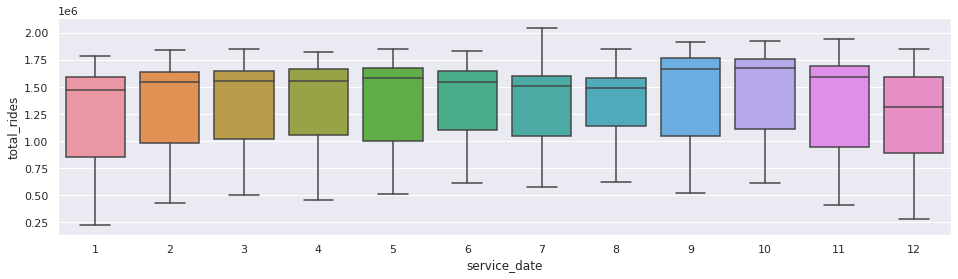

In [12]:
# visualising the distributiuon according to the months in a year

months = df.index.to_series().dt.month

fig = sns.boxplot(x=months, y=df[target_col])

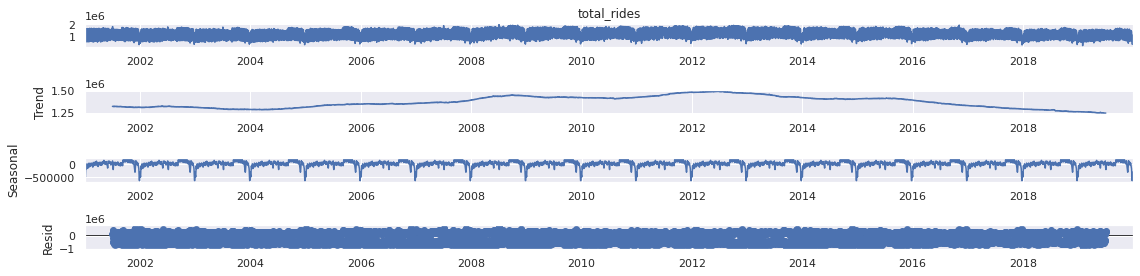

In [13]:
# visualising the data into trend and seasonal and residual components

result = seasonal_decompose(df[target_col], period=365)
fig = result.plot()

## Storing the data inm a csv file.


In [14]:
df[[target_col]].to_csv(processed_file, index=True, index_label=ts_col)

# Training a Model

In [15]:
# Importing all the necessary modules and packages
import warnings
# importing the google cloud staorageto access the storage bucket
from google.cloud import storage

# importing the metrics for evaluating the results
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# importing preprocessing modules from sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# importing tensorflow package to create a model
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, LSTM, MaxPooling1D

In [16]:
# initialising the bucket variables for storage
BUCKET = 'vertex-ai-projects'
BUCKET_URI = 'gs://' + BUCKET

In [17]:
# Parameters for Model

# Daily frequency
freq = 'D' 

# Lookback window
n_input_steps = 30 

# How many steps to predict forward
n_output_steps = 7 

# Periodicity month wise
n_seasons = 7 

# % Split between train/test data for our dataset
train_split = 0.8 

# Epochs
epochs = 1000 

# this parameters stops the training if the loss stops decreasing after no. of steps.
patience = 5 

In [18]:
# Building a cloud storage bucket on GCP

# initiating a storage session client
storage_client = storage.Client()

# to create bucket if it doesn't exist
try:
    bucket = storage_client.get_bucket(BUCKET)
    print('Bucket already exists')
except:
    bucket = storage_client.create_bucket(BUCKET)
    print('Created bucket: ' + BUCKET)

Bucket already exists


### Loading the data

In [20]:
import os
processed_file = 'cta_ridership.csv' 

# loading data if it doesnt exists in the sys
if os.path.exists(processed_file):
    input_file = processed_file 
else:
    input_file = f'data/{processed_file}'
    

df = pd.read_csv(input_file, index_col=ts_col, parse_dates=True)
df.index.freq = freq

df.head()

total_rides
service_date             
2001-01-01         423647
2001-01-02        1282779
2001-01-03        1361355
2001-01-04        1420032
2001-01-05        1448343

In [21]:
# no. of features in the dataset
n_features = len(df.columns)

# Index of target column
target_col_num = df.columns.get_loc(target_col)

In [22]:
# Splitting the data into test/train 
size = int(len(df) * train_split)

# Creating test/train splits
df_train, df_test = df[0:size].copy(deep=True), df[size:len(df)].copy(deep=True)

df_train.head()

total_rides
service_date             
2001-01-01         423647
2001-01-02        1282779
2001-01-03        1361355
2001-01-04        1420032
2001-01-05        1448343

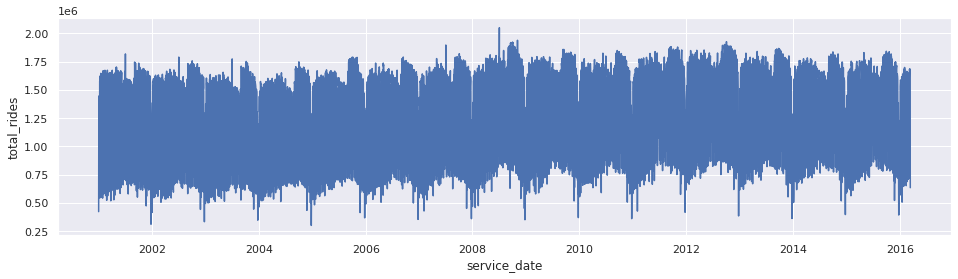

In [23]:
_=sns.lineplot(data=df_train[target_col]) 

In [24]:
df[target_col].sort_values(ascending=False).head()

service_date
2008-07-03    2049519
2016-11-04    1945417
2008-11-04    1938738
2012-10-03    1926454
2008-10-01    1922280
Name: total_rides, dtype: int64

In [26]:
import numpy as np
# removing any outlier present that can pollute the dataset
threshold = 2000000 

# setting all values above threshold to NaNs
df_train.loc[df_train[target_col] > threshold, target_col] = np.nan

# interpolating the dataset
df_train = df_train.interpolate()

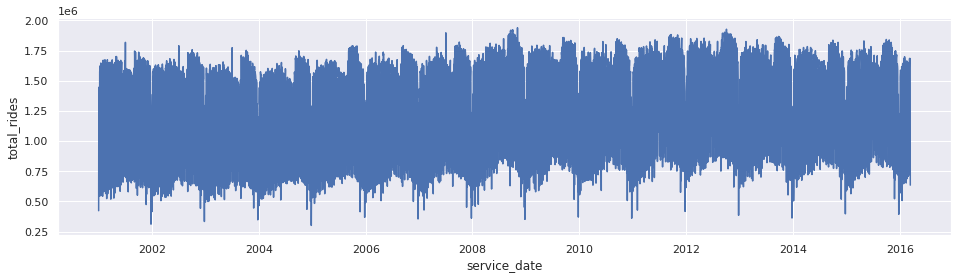

In [27]:
_=sns.lineplot(data=df_train[target_col])

Preprocessing the dataset for better Results

In [28]:
# Scaling and Transforming the dataset functions
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# scaling the input features and target column
# Using seaprate scaler for target column
def scale(df, 
          fit=True, 
          target_col=target_col,
          feature_scaler=feature_scaler,
          target_scaler=target_scaler):
    # reshaping the target column values
    target = df[target_col].values.reshape(-1, 1)
    if fit:
        target_scaler.fit(target)
    target_scaled = target_scaler.transform(target)
    
    features = df.loc[:, df.columns != target_col].values
    
    if features.shape[1]:  
        if fit:
            feature_scaler.fit(features)
        features_scaled = feature_scaler.transform(features)
        
        # aggregating the feature and target column after scaling and transforming
        df_scaled = pd.DataFrame(features_scaled)
        target_col_num = df.columns.get_loc(target_col)
        df_scaled.insert(target_col_num, target_col, target_scaled)
        df_scaled.columns = df.columns        
    
    else:  
        df_scaled = pd.DataFrame(target_scaled, columns=df.columns)
      
    return df_scaled

# transofrming the scaled values back to their inital values
def inverse_scale(data, target_scaler=target_scaler):
    
    df = pd.DataFrame()
    data_scaled = np.empty([data.shape[1], data.shape[0]])
    for i in range(data.shape[1]):
        # using inverse_transofrm function
        data_scaled[i] = target_scaler.inverse_transform([data[:,i]])
    return data_scaled.transpose()

df_train_scaled=scale(df_train)
df_test_scaled=scale(df_test, False)

### Creating sequences of our data

In [29]:
def reframe(data, n_input_steps = n_input_steps, n_output_steps = n_output_steps, target_col = target_col):

    # getting the index of target column
    target_col_num = data.columns.get_loc(target_col)    
    
    df = pd.DataFrame(data)
    cols=list()
    for i in range(n_input_steps, 0, -1):
        cols.append(df.shift(i))
    for i in range(0, n_output_steps):
        cols.append(df.shift(-i))
        
    # Concatenating values 
    df = pd.concat(cols, axis=1)
    
    # dropping all the NaN values
    df.dropna(inplace=True)
    
    # Splitting the data into feature and label columns
    n_feature_cols = n_input_steps * n_features
    features = df.iloc[:,0:n_feature_cols]
    target_cols = [i for i in range(n_feature_cols + target_col_num, n_feature_cols + n_output_steps * n_features, n_features)]
    targets = df.iloc[:,target_cols]

    return (features, targets)

# finally storing the reframed dataset
X_train_reframed, y_train_reframed = reframe(df_train_scaled)
X_test_reframed, y_test_reframed = reframe(df_test_scaled)

### evaluating the results of the model

In [30]:
# to print the statistics summary of our model
def print_stats(timestep, y_true, y_pred, target_col, chart=True, table=False, dec=3):
    
    print('=== t+' + str(timestep) + ' ===')
    print('R^2:  ' + str(np.round(r2_score(y_true, y_pred), dec)))
    print('MAPE: ' + str(np.round(mean_absolute_percentage_error(y_true, y_pred), dec)))
    print('MAE:  ' + str(np.round(mean_absolute_error(y_true, y_pred), dec)))
    print('')

    df_y_true = pd.DataFrame(y_true)
    df_y_true[target_col + '_pred'] = np.round(y_pred, dec)
    
    if table:
        print(str(df_y_true.head(5)) + '\n')
        print(str(df_y_true.tail(5)) + '\n')
    if chart:
        sns.lineplot(data=df_y_true[[target_col, target_col+'_pred']])
        plt.show()

# function to process predictions to match the size and index of true values.
def evaluate(y_pred,
             exclude_timesteps=n_input_steps,
             y_true=df_test,
             target_col=target_col):

        
    # Number of predictions
    outputs = y_pred.shape[1]
    
    target_col_num = df.columns.get_loc(target_col)
    
    # creating list for true and predicted after evaluation
    y_true_eval, y_pred_eval = list(), list()

    # creating list for true and predicted for all time stamps
    y_true_all, y_pred_all = np.array([]), np.array([])
    
    # adding the y_true_eval,y_pred_eval list with the output for all the timestamps
    for t in range(outputs):
        if exclude_timesteps:
            y_true_eval.append(y_true[exclude_timesteps+t:len(y_true)-outputs+t+1].copy())
            y_pred_eval.append(y_pred[:,t])          
        else:
            y_true_eval.append(y_true[t:].copy())
            y_pred_eval.append(y_pred[:-1*t-1,t])
        # adding the output vavlues to the aggregated list
        # concatenating the values
        y_true_all = np.concatenate([y_true_all, y_true_eval[t].values[:,target_col_num]], axis=0)
        y_pred_all = np.concatenate([y_pred_all, y_pred_eval[t]], axis=0)

    # Printing the statistics summary
    if outputs > 1:
        print_stats('(1-' + str(outputs) + ')', y_true_all, y_pred_all, target_col, False)

    # Printing the statistics summary for next future time steps
    for t in range(outputs):    
        print_stats(t+1, y_true_eval[t][target_col], y_pred_eval[t], target_col, True)

## Testing out models for our datasets

### 1. LSTM

Reshaping the datasetso that input values to match ouput

In [31]:
X_train = X_train_reframed.values.reshape(-1, n_input_steps, n_features)
X_test = X_test_reframed.values.reshape(-1, n_input_steps, n_features)
y_train = y_train_reframed.values.reshape(-1, n_output_steps, 1)
y_test = y_test_reframed.values.reshape(-1, n_output_steps, 1)

In [33]:
model = Sequential([
    LSTM(64, input_shape=[n_input_steps, n_features]),
    Dense(n_output_steps)])

model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=patience)
_ = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])

Epoch 1/1000
173/173 [==============================] - 8s 33ms/step - loss: 0.6513 - val_loss: 0.4345
Epoch 2/1000
173/173 [==============================] - 5s 28ms/step - loss: 0.3312 - val_loss: 0.2855
Epoch 3/1000
173/173 [==============================] - 5s 27ms/step - loss: 0.2415 - val_loss: 0.2364
Epoch 4/1000
173/173 [==============================] - 5s 30ms/step - loss: 0.2256 - val_loss: 0.2300
Epoch 5/1000
173/173 [==============================] - 5s 29ms/step - loss: 0.2202 - val_loss: 0.2288
Epoch 6/1000
173/173 [==============================] - 5s 30ms/step - loss: 0.2154 - val_loss: 0.2354
Epoch 7/1000
173/173 [==============================] - 5s 27ms/step - loss: 0.2103 - val_loss: 0.2159
Epoch 8/1000
173/173 [==============================] - 5s 26ms/step - loss: 0.2093 - val_loss: 0.2224
Epoch 9/1000
173/173 [==============================] - 5s 27ms/step - loss: 0.2064 - val_loss: 0.2120
Epoch 10/1000
173/173 [==============================] - 5s 29ms/step - l

In [34]:
model.save('./lstm_export/')

2021-12-14 23:59:29.340040: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./lstm_export/assets


INFO:tensorflow:Assets written to: ./lstm_export/assets


=== t+(1-7) ===
R^2:  0.804
MAPE: 0.094
MAE:  81568.099

=== t+1 ===
R^2:  0.854
MAPE: 0.079
MAE:  67513.909



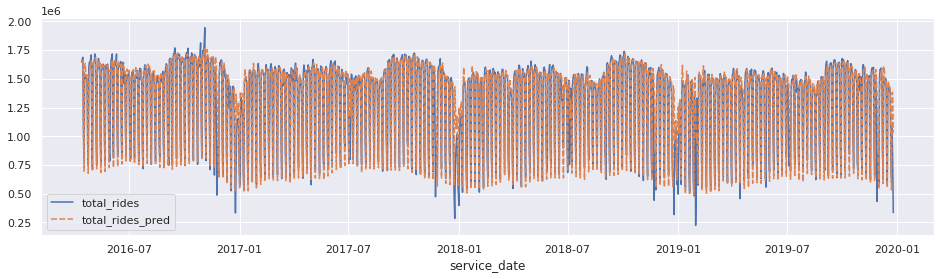

=== t+2 ===
R^2:  0.815
MAPE: 0.091
MAE:  77616.522



=== t+3 ===
R^2:  0.801
MAPE: 0.094
MAE:  81734.49



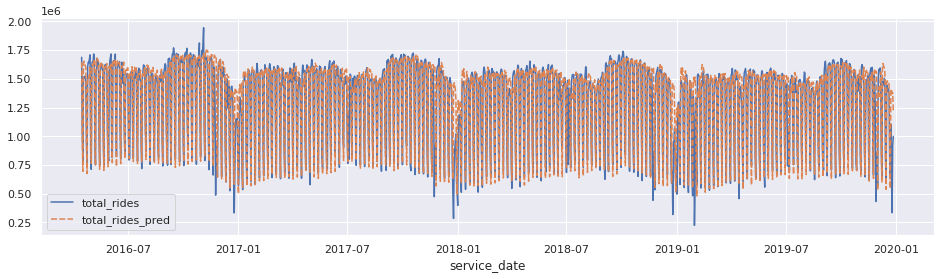

=== t+4 ===
R^2:  0.795
MAPE: 0.096
MAE:  83786.283



=== t+5 ===
R^2:  0.782
MAPE: 0.101
MAE:  88383.897



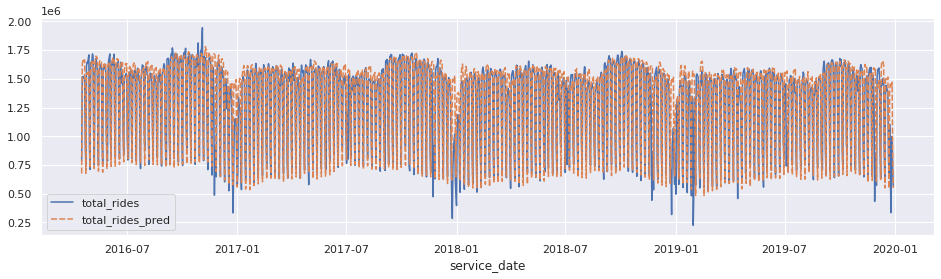

=== t+6 ===
R^2:  0.79
MAPE: 0.099
MAE:  86279.973



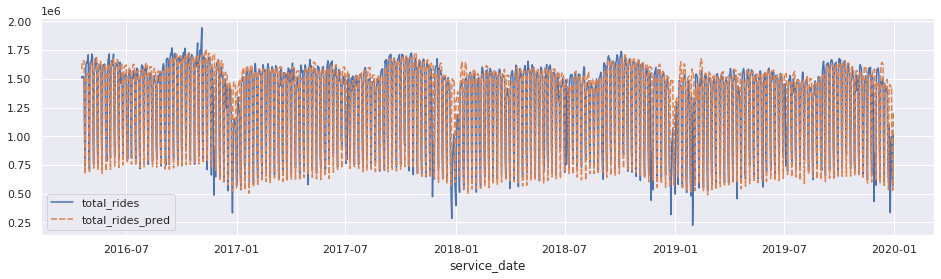

=== t+7 ===
R^2:  0.79
MAPE: 0.098
MAE:  85661.619



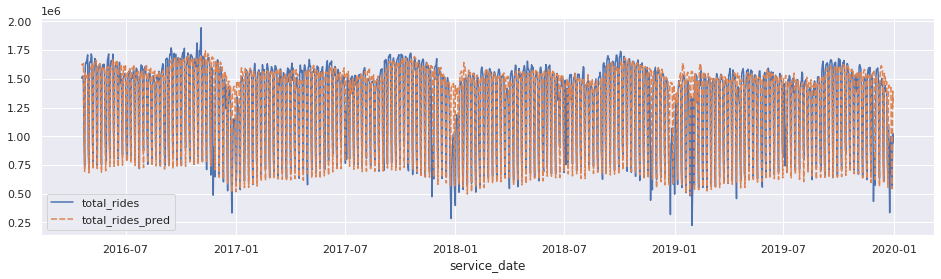

In [35]:
# predicting the results

preds = model.predict(X_test)
y_pred_lstm = inverse_scale(preds)

# Evaluating the results for every time stamps
evaluate(y_pred_lstm)



### 2. CNN

In [36]:
from tensorflow.keras.layers import AveragePooling1D

model = Sequential([
    Conv1D(filters=32, kernel_size=3, input_shape=[n_input_steps, n_features]),
    Flatten(),
    Dense(n_output_steps)])

model.compile(optimizer='adam', loss='mae')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
_ = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=epochs, callbacks=[early_stopping])

Epoch 1/1000
173/173 [==============================] - 2s 7ms/step - loss: 0.3000 - val_loss: 0.2555
Epoch 2/1000
173/173 [==============================] - 1s 7ms/step - loss: 0.2494 - val_loss: 0.2467
Epoch 3/1000
173/173 [==============================] - 1s 4ms/step - loss: 0.2467 - val_loss: 0.2485
Epoch 4/1000
173/173 [==============================] - 1s 4ms/step - loss: 0.2461 - val_loss: 0.2449
Epoch 5/1000
173/173 [==============================] - 1s 5ms/step - loss: 0.2457 - val_loss: 0.2456
Epoch 6/1000
173/173 [==============================] - 1s 5ms/step - loss: 0.2451 - val_loss: 0.2490
Epoch 7/1000
173/173 [==============================] - 1s 5ms/step - loss: 0.2448 - val_loss: 0.2466
Epoch 8/1000
173/173 [==============================] - 1s 4ms/step - loss: 0.2442 - val_loss: 0.2469
Epoch 9/1000
173/173 [==============================] - 1s 4ms/step - loss: 0.2442 - val_loss: 0.2456


In [37]:
model.save('./cnn_export/')

INFO:tensorflow:Assets written to: ./cnn_export/assets


INFO:tensorflow:Assets written to: ./cnn_export/assets


=== t+(1-7) ===
R^2:  0.767
MAPE: 0.102
MAE:  96752.773

=== t+1 ===
R^2:  0.808
MAPE: 0.091
MAE:  87145.578



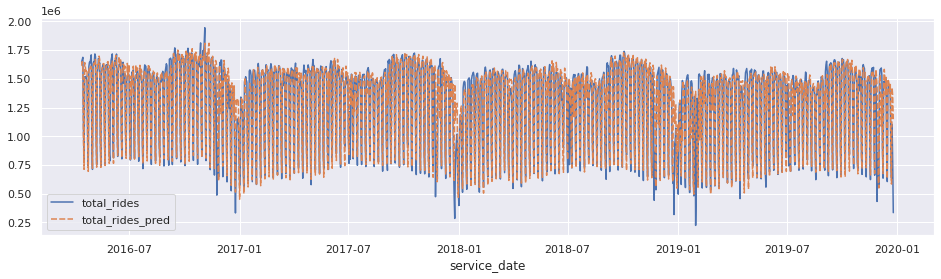

=== t+2 ===
R^2:  0.768
MAPE: 0.101
MAE:  96637.9



=== t+3 ===
R^2:  0.762
MAPE: 0.106
MAE:  98503.076



=== t+4 ===
R^2:  0.75
MAPE: 0.106
MAE:  101441.772



=== t+5 ===
R^2:  0.754
MAPE: 0.105
MAE:  100100.379



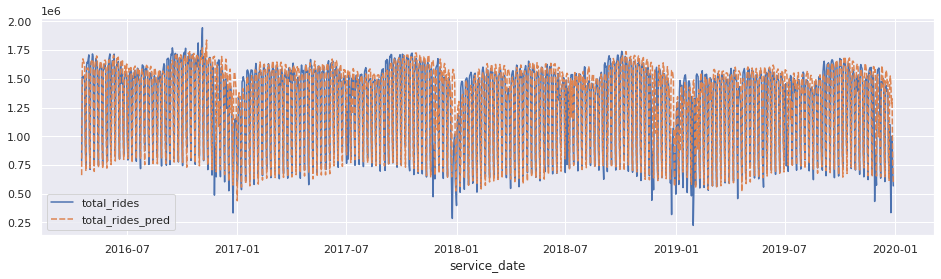

=== t+6 ===
R^2:  0.764
MAPE: 0.104
MAE:  97005.987



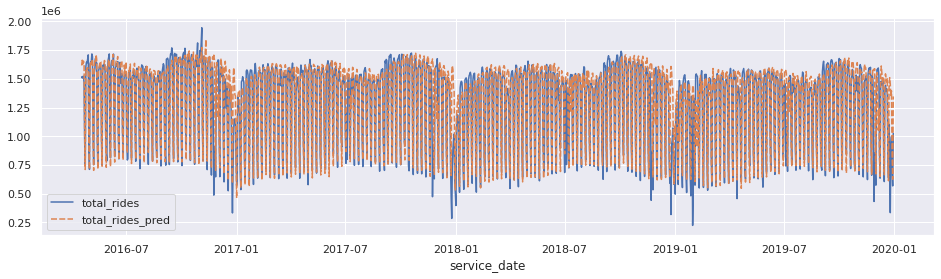

=== t+7 ===
R^2:  0.766
MAPE: 0.104
MAE:  96434.721



In [38]:
preds = model.predict(X_test)
y_pred_cnn = inverse_scale(preds)

evaluate(y_pred_cnn)

### 3. Naive models

3.1 Random Walk

In [39]:
from statsmodels.tsa.arima.model import ARIMA

# imlementing standard arima model
hist = df_train[target_col].copy() 

# specifying the dataframe frequency
hist.index.freq = pd.infer_freq(hist.index) 

# specifying the number of predictions
n_pred = len(df_test) + 1 

# array to carry predictions values
y_pred_rw = np.empty([n_pred,n_output_steps]) 

for t in range(n_pred):
    mod = ARIMA(hist, order=(0, 1, 0))
    res = mod.fit()
    pred = res.forecast(n_output_steps)
    y_pred_rw[t] = pred.values
    if t < n_pred - 1:
        hist.loc[df_test.iloc[t].name] = df_test[target_col][t]
        hist.index.freq = pd.infer_freq(hist.index)

=== t+(1-7) ===
R^2:  -0.834
MAPE: 0.366
MAE:  364578.376

=== t+1 ===
R^2:  -0.19
MAPE: 0.257
MAE:  269441.826



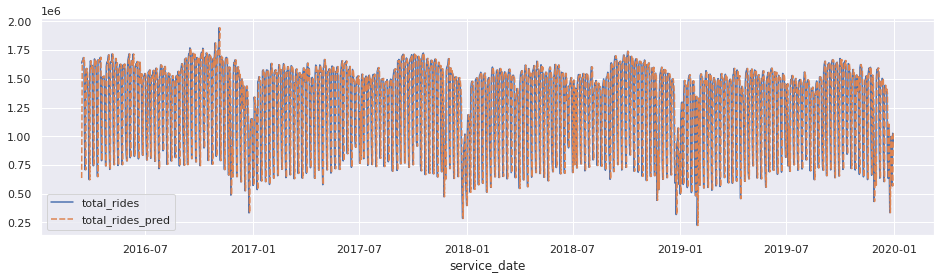

=== t+2 ===
R^2:  -1.383
MAPE: 0.452
MAE:  451553.613



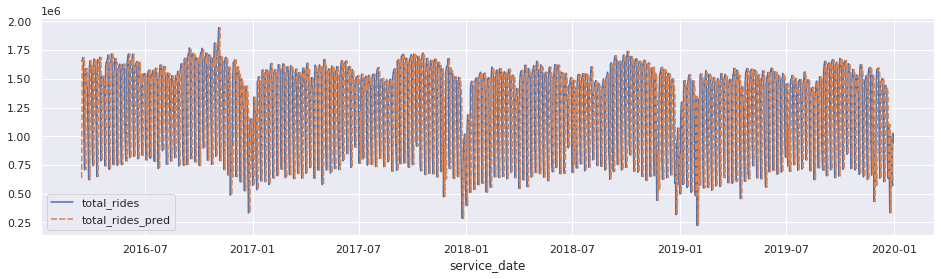

=== t+3 ===
R^2:  -1.578
MAPE: 0.477
MAE:  481055.998



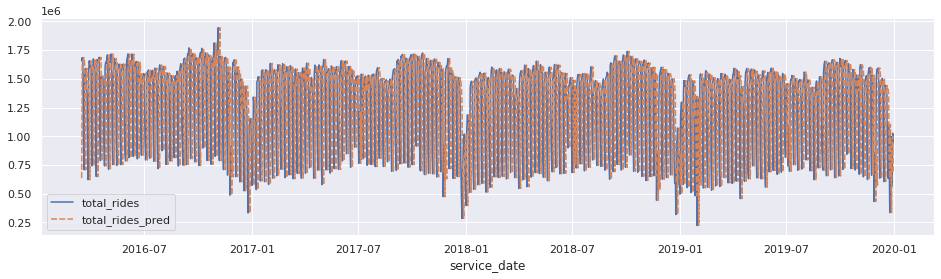

=== t+4 ===
R^2:  -1.6
MAPE: 0.479
MAE:  483747.76



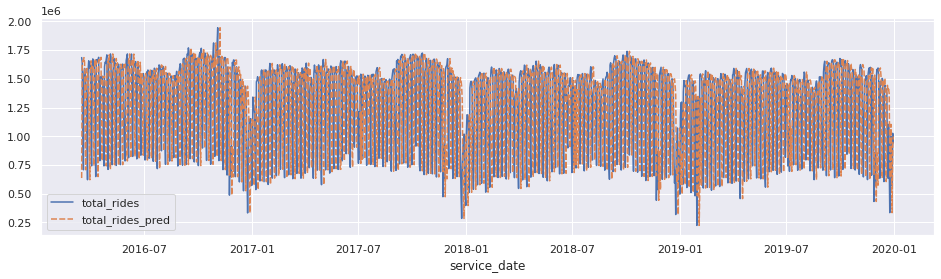

=== t+5 ===
R^2:  -1.44
MAPE: 0.464
MAE:  461959.034



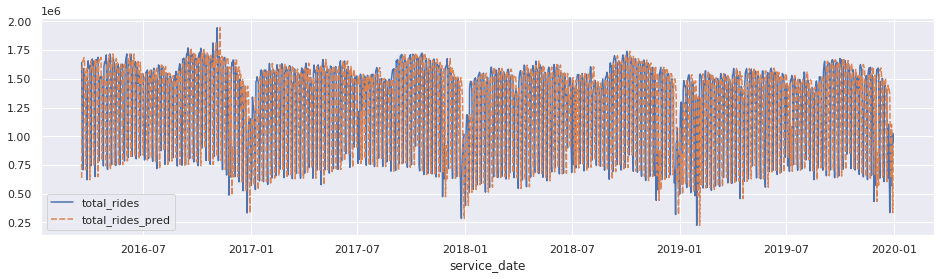

=== t+6 ===
R^2:  -0.322
MAPE: 0.325
MAE:  294900.779



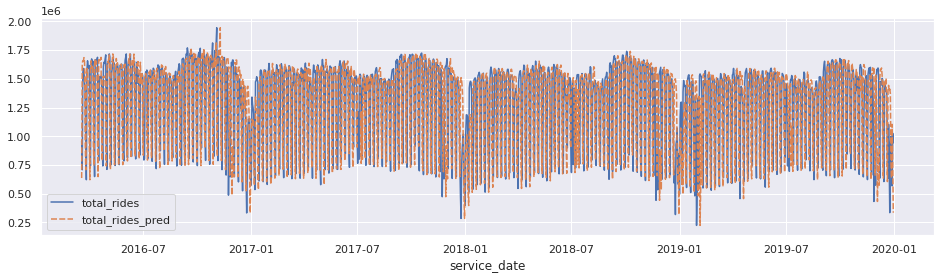

=== t+7 ===
R^2:  0.675
MAPE: 0.11
MAE:  108801.663



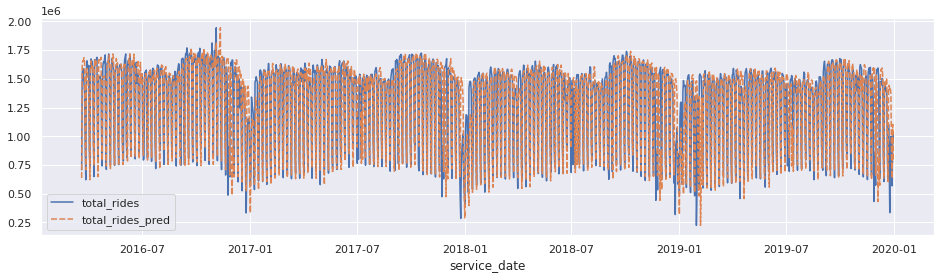

In [40]:
evaluate(y_pred_rw, 0)

3.2 Seasonal Naive

In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

hist = df_train[target_col].copy() 

# specifying the dataframe frequency
hist.index.freq = pd.infer_freq(hist.index) 

# specifying the number of predictions
n_pred = len(df_test) + 1 

# array to carry predictions values
y_pred_sn = np.empty([n_pred,n_output_steps]) 

for t in range(n_pred):
    mod = SARIMAX(hist, order=(0, 0, 0), seasonal_order=(0, 1, 0, n_seasons))
    res = mod.fit(disp=False)
    pred = res.forecast(n_output_steps)
    y_pred_sn[t] = pred.values
    if t < n_pred - 1:
        hist.loc[df_test.iloc[t].name] = df_test[target_col][t] 
        hist.index.freq = pd.infer_freq(hist.index)

=== t+(1-7) ===
R^2:  0.675
MAPE: 0.11
MAE:  108722.34

=== t+1 ===
R^2:  0.676
MAPE: 0.11
MAE:  108556.529



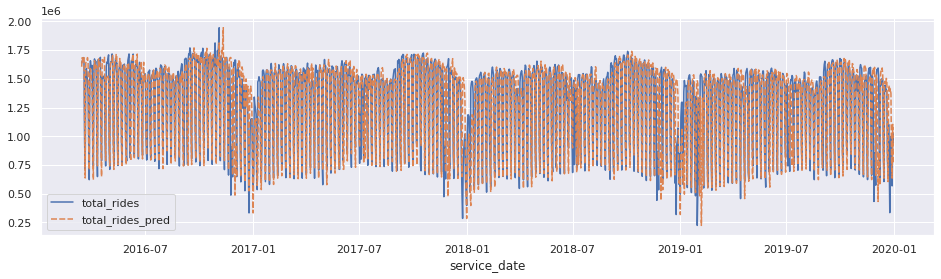

=== t+2 ===
R^2:  0.675
MAPE: 0.11
MAE:  108611.732



=== t+3 ===
R^2:  0.675
MAPE: 0.11
MAE:  108670.502



=== t+4 ===
R^2:  0.675
MAPE: 0.11
MAE:  108745.292



=== t+5 ===
R^2:  0.675
MAPE: 0.11
MAE:  108812.016



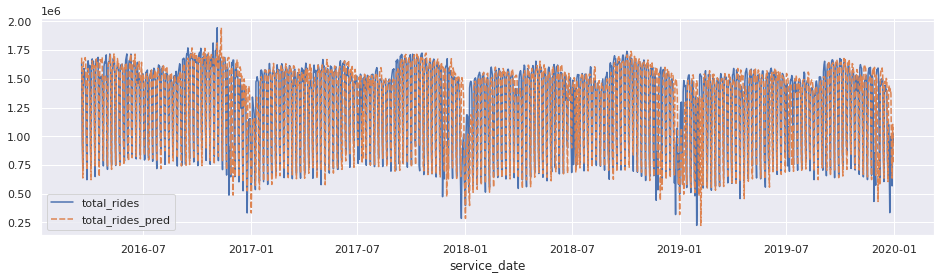

=== t+6 ===
R^2:  0.675
MAPE: 0.11
MAE:  108859.638



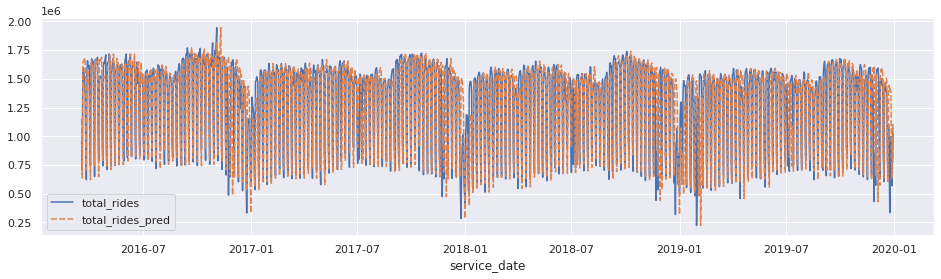

=== t+7 ===
R^2:  0.675
MAPE: 0.11
MAE:  108801.663



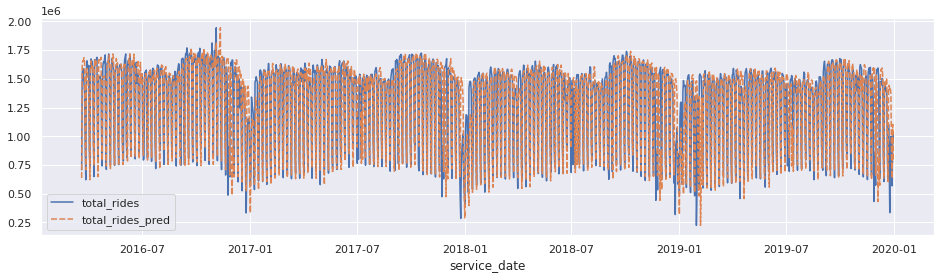

In [42]:
evaluate(y_pred_sn, 0)

## Statistical Models

In [ ]:
# Exponential Smoothing

hist = df_train[target_col].copy() 

# specifying the dataframe frequency
hist.index.freq = pd.infer_freq(hist.index) 

# specifying the number of predictions
n_pred = len(df_test) + 1 

# array to carry predictions values
y_pred_es = np.empty([n_pred,n_output_steps]) 

for t in range(n_pred):
    mod = ExponentialSmoothing(hist, seasonal_periods=n_seasons, trend='add', seasonal='add', damped_trend=True, use_boxcox=False, initialization_method='heuristic')
    res = mod.fit(method='L-BFGS-B')  
    pred = res.forecast(n_output_steps)
    y_pred_es[t] = pred.values
    if t < n_pred - 1:
        hist.loc[df_test.iloc[t].name] = df_test[target_col][t] 
        hist.index.freq = pd.infer_freq(hist.index)

In [ ]:
evaluate(y_pred_es, 0)

### Ensembling the Statistical and ML models

In [ ]:
def trunc(df, test_set=df_test, n_input_steps = n_input_steps, n_output_steps = n_output_steps):
    return df[n_input_steps: -n_output_steps]

y_pred_es_trunc = trunc(y_pred_es)
y_true_trunc = trunc(df_test)

In [ ]:
models = [y_pred_lstm, y_pred_cnn, y_pred_es_trunc]
weights = [2, 1, 1]

y_pred_ensemble = np.average( np.array(models), axis=0, weights=weights)

evaluate(y_pred_ensemble, 0, y_true_trunc)